# Regularyzacja Sieci Neuronowych

Za pomocą poniższego skryptu proszę pobrać zbiór danych - jest to zmniejszona wersja MNISTa na potrzeby ćwiczenia. Jeśli sieci uczą się zbyt wolno, można spróbować dostosować parametr `shrinkage`. Mówi on o tym, jak duża część zbioru danych jest wczytywana.

In [15]:
%matplotlib inline
import torch
from utils import load_mnist, show_results, ModelTrainer
from checker import test_droput, test_bn


torch.manual_seed(44)

train_dataset = load_mnist(train=True, shrinkage=0.01)
test_dataset = load_mnist(train=False, shrinkage=0.1)

Poniższy blok ustawia parametry wspólne dla wszystkich porównywanych w notebooku modeli. Powinny być one ustawione tak, aby wszystkie modele zdążyły się nauczyć zadania do granic swoich możliwości (wypłaszczenie funkcji kosztu) - zaproponowane parametry powinny być w porządku, ale modele mogą liczyć się powoli.

In [16]:
n_epochs = 300
learning_rate = 0.05
batch_size = 128

trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

Następnie przy użyciu modułu `torch.nn.Sequential`, który tworzy sieć neuronową przez sekwencyjne łączenie podanych warstw, budujemy sieć neuronową z 2 warstwami ukrytymi o wielkości 256 i aktywacją ReLU między nimi. Sieć ta posłuży nam jako baseline, a w dalszej części notebooka będziemy dodawać do modelu dodatkowe warstwy i porównywać wyniki.

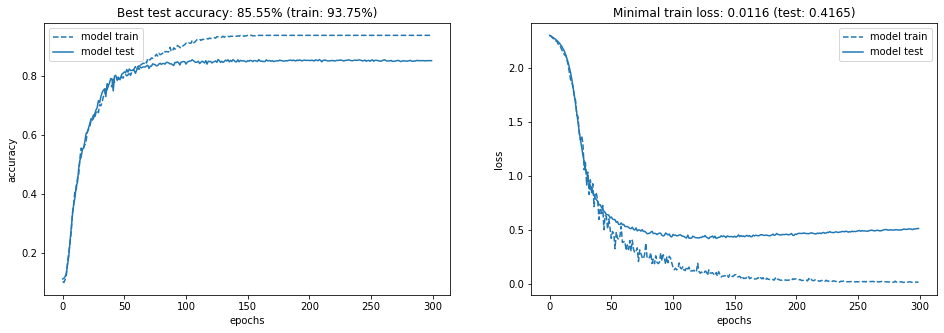

In [189]:
model = torch.nn.Sequential(torch.nn.Linear(784, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=history)

Sieć osiąga około 85,5% dokładności $^*$ na zbiorze testowym. Na wykresie funkcji kosztu widać, że krzywa testowa w okolicach 100-tnej epoki $^*$ zaczyna się unosić, a dokładność przestaje rosnąć. Świadczy to o tym, że model zaczyna za bardzo dopasowywać się do danych (**overfitting**). Aby otrzymać najlepszy model dla tej architektury, należałoby wczytać parametry z momentu, gdy dokładność testowa była najwyższa (tzw. **early stopping**). W dalszej części rozważymy architektury z regularyzacjami poprawiającymi ten wynik.

$^*$ liczby dotyczą proponowanych domyślnych parametrów

### Regularyzacje Oparte o Funkcję Kosztu

Podstawowym sposobem regularyzacji, w którym nie ingerujemy w architekturę, jest dodanie do funkcji kosztu $J(\Theta;X,y)$ kary $\Omega(\Theta)$ związanej z parametrami. Kara jest regulowana przez współczynnik $\alpha \in [0, \infty)$.

\begin{equation*}
\tilde{J}(\Theta;X,y) = J(\Theta;X,y) + \alpha \Omega(\Theta)
\end{equation*}

Podstawowym wyborem przy doborze kary jest norma **L1** lub **L2** na wagach sieci. Zwykle dążymy do uproszczenia modelu, a więc zmniejszenia wariancji, dlatego **norma jest stosowana tylko na wagach, z pominięciem biasów**.

### Zadanie 1. Dropout (3 pkt.)

Dropout jest warstwą „wyłączającą” część neuronów, przez co model staje się bardziej odporny na overfitting.

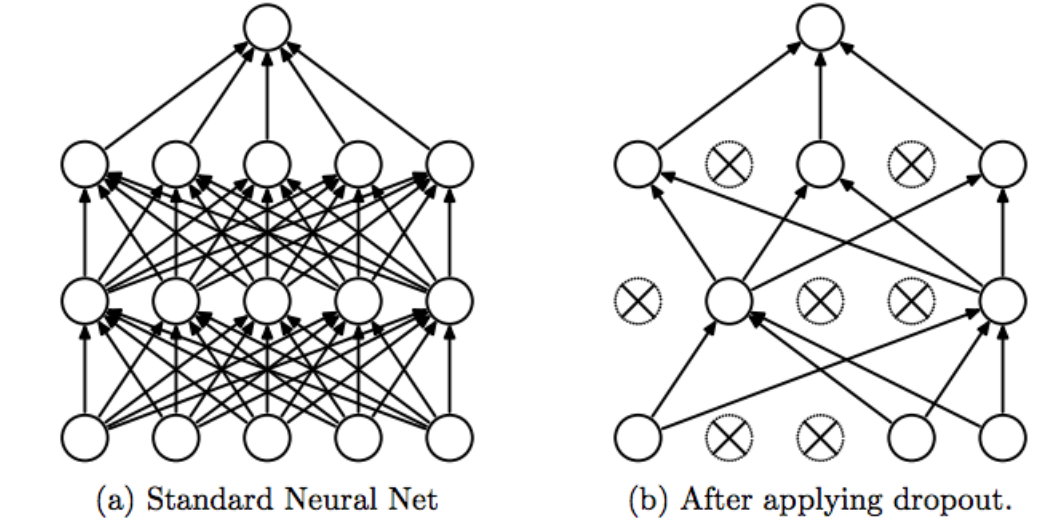

Pytania: 

1. Jaka intuicja regularyzacyjna stoi za pozostawieniem tylko części cech w trakcie nauki?
2. Co można powiedzieć o krzywej dokładności na zbiorze treningowym z użyciem Dropoutu w porównaniu do modelu baseline'owego?
3. W jaki sposób sieć z warstwą dropout można traktować jako ensemble (połączenie wielu modelów)?
4. Dlaczego powinniśmy skalować aktywacje o stałą w treningu lub w teście?

**Odpowiedź na powyższe pytania jest częścią zadania. W poszukiwaniu odpowiedzi należy się posiłkować oryginalną publikacją wprowadzającą Dropout [1].**


Hint do implementacji: [`torch.bernoulli`](https://pytorch.org/docs/stable/torch.html#torch.bernoulli). 
**Zakładamy, że chcemy wykonywać skalowanie w treningu.**

In [195]:
"""
1. Intuicja jest taka, żeby uśrednić predykcje ze wszystkich możliwych ustawień parametrów.
2. Accuracy się zwiększa również na zbiorze treningowym - to pokazuje krzywa dokładności.
3. Enseble jest wtedy, gdy przewidywania kilku trenowanych modeli są łączone.
W wyniku wygaszania neuronów w dropoutcie powstaje wiele różnych sieci,
z których łączy się wynik, więc użycie określenia "enseble" jest zasadne.
4. Ponieważ jest dobrym przybliżeniem średniej modelu, gdzie w artykule
porównano uśrednianie przy pomocy skalowania z uśrednianiem przy pomocy
modelu Monte-Carlo i uzasadniono poprawność skalowania.
"""


class Dropout(torch.nn.Module):
    
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
  
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = x.to(device)
        if self.training:
            bernoulli = torch.distributions.bernoulli.Bernoulli(probs=1-self.p)
            sample =  bernoulli.sample(x.size()) * (1.0/(1-self.p))
            sample = sample.to(device)
            ans = x * sample
            return ans#.to("cpu")    #ODKOMENTOWANE DLA test_dropout!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        else:
            return x


In [193]:
test_droput(Dropout)

Do modelu baseline'owego po każdej warstwie należy dodać dropout z prawdopodobieństwem zachowania neuronów równym 50%. (można eksperymentować z niestandardowymi wartościami)

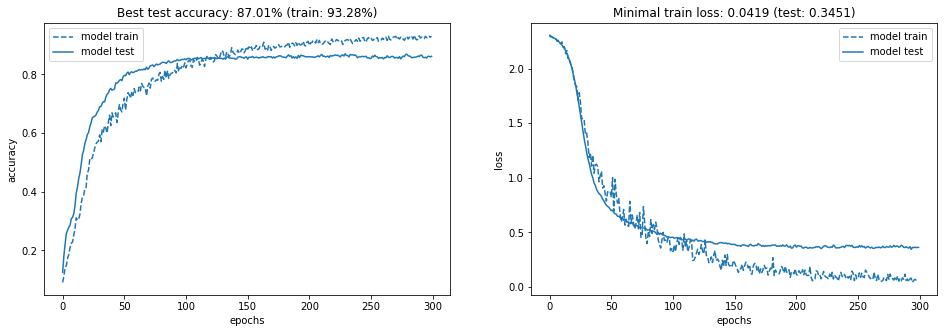

In [196]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 10)
)


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
dropout_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=dropout_history)

### Zadanie 2. Batch Normalization (4 pkt.)

Batch Normalization jest techniką redukującą **internal covariate shift (przesunięcie rozkładu danych)** (ale czy na pewno? [[3]](https://arxiv.org/pdf/1805.11604.pdf)) poprzez normalizację wyjścia poszczególnych warstw. Wraz ze zmianą parametrów warstwy poprzedniej zmienia się domena zadania dla warstwy kolejnej. Dzięki normalizacji uczenie jest szybsze i bardziej stabilne - można użyć wyższych wartości współczynnika uczenia, normalizacja redukuje zanikanie i wybuchanie gradientów.

**Oznaczenia:**
* $ x_i $ - wektor z wejścia $x$ do warstwy BatchNorm
* $ y_i $ - wektor z wyjścia $y$ z warstwy BatchNorm
* $ \gamma $ - *scale*, uczony parametr, inicjalizowana na ???
* $ \beta $ - *shift*, uczony parametr, inicjalizowana na ???
* $ \overline{\mu} $ - średnia krocząca średniej batcha, inicjalizowana na ???
* $ \overline{\sigma} $ - średnia krocząca wariancji batcha, inicjalizowana na ???
* $\lambda$ - momentum do średnich kroczących



<font size=2> $$ \mu_B  = \frac{1}{m} \sum_{i=1}^m x_i $$ </font>
<font size=2>$$ \sigma^2_B  = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_b)^2 $$ </font>
<font size=2> $$ \hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} $$ </font>
<font size=2> $$ y_i = \gamma \hat{x_i} + \beta $$ </font>

Dodatkowo potrzebujemy:

<font size=2> $$ \overline{\mu}_{t+1} =  (1 - \lambda) \overline{\mu}_{t} + \lambda \mu_B $$ </font>
<font size=2> $$ \overline{\sigma^2}_{t+1} =  (1 - \lambda) \overline{\sigma^2}_{t} + \lambda \sigma^2_B $$ </font>

**Pytania:**
1. Jak BN może zapobiegać zanikającym gradientom? Wytłumaczyć na przykładzie aktywacji sigmoidalnej $\sigma(x) = \frac{1}{1+e^{-x}}$.
2. Czy BN powinien być stosowany przed czy po aktywacji i dlaczego? (Wskazówka: nie ma złych odpowiedzi)
3. Czy można BN traktować jako regularyzację sieci neuronowej? Dlaczego?


**Odpowiedź na powyższe pytania jest częścią zadania. W poszukiwaniu odpowiedzi należy się posiłkować publikacjami dotyczącymi batch normalization [2, 3].**

In [178]:
"""
1. Dla funkcji sigmoidalnej sprawi, że funkcja ta nie będzie przyjmować krańcowych wartości, tj.
bliskich 0 lub 1, ponieważ argumenty do niej trafiające będą w przedziale, gdzie nie ma
wartości bliskich 0 lub 1. Zapobiegnie to temu, że gradient stanie się zbyt mały.

2. Celem użycia BN jest uzyskanie w outpucie zerowej średniej i wariancji jednostkowej.
Umieszczenie funkcji aktywacji, np. ReLu po BN sprawi, że średnia nie będzie zerowa,
a wariancja będzie mniejsza jednostkowa.
Zatem lepiej umieszczać BN po aktywacji.

3. Tak, ponieważ BN regularyzuje model i w niektórych przypadkach eliminuje potrzebę skorzystania z Dropoutu.



"""


class BatchNorm(torch.nn.Module):
    
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        shape = (1, num_features)

        self.gamma = torch.nn.Parameter(torch.ones(shape))
        self.beta = torch.nn.Parameter(torch.zeros(shape))
        
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        

    def forward(self, x):
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
        
        if self.training:
            self.mu = x.mean(dim=0)
            self.sigma = ((x - self.mu) ** 2).mean(dim=0)

            self.moving_mean = (1.0 - self.momentum) * self.moving_mean + self.momentum * self.mu
            self.moving_var = (1.0 - self.momentum) * self.moving_var + self.momentum * self.sigma
            
            X_hat = (x - self.mu) / torch.sqrt(self.sigma + self.eps)
            
            Y = self.gamma * X_hat + self.beta  
            
            return Y
            
        else:
            X_hat = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)

            Y = self.gamma * X_hat + self.beta 
            
            return Y
  

In [179]:
test_bn(BatchNorm)

Do modelu baseline'owego należy dodać Batch Normalization po każdej warstwie.

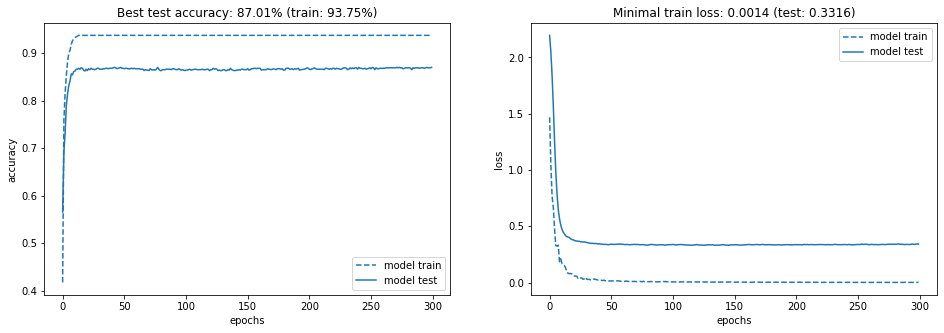

In [180]:
model = torch.nn.Sequential(torch.nn.Linear(784, 256), 
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
bn_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=bn_history)

### Podsumowanie

Poniżej załączony oczekiwany rezultat eksperymentów dla zaproponowanych parametrów.

In [190]:
show_results(vanilla=history, dropout=dropout_history, bn=bn_history, 
             orientation='vertical', accuracy_bottom=0.8, loss_top=0.6)

NameError: name 'dropout_history' is not defined

### Literatura
 
1. [Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting."](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

2. [Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift."](https://arxiv.org/pdf/1502.03167.pdf)

3. [Santurkar, Shibani, et al. "How does batch normalization help optimization?(no, it is not about internal covariate shift)."](https://arxiv.org/pdf/1805.11604.pdf)